The following manifold and latent dynamic metrics are included:
- Principal Component Analysis (PCA)
- Participation Ratio (PR)
- Tangling
- Subspace Angle
- Procrustes Distance


In [1]:
from pathlib import Path
import argparse
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d

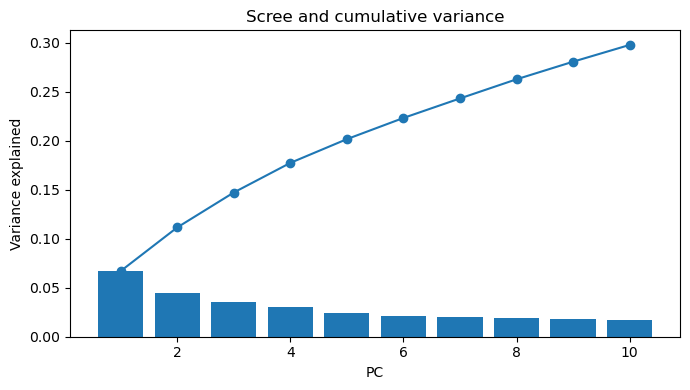

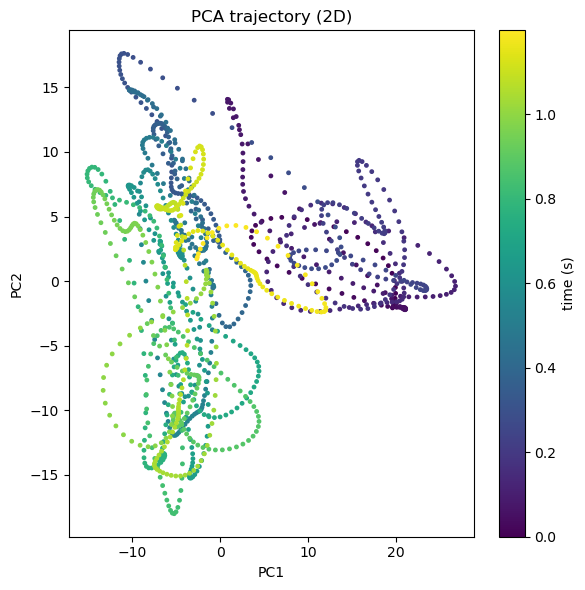

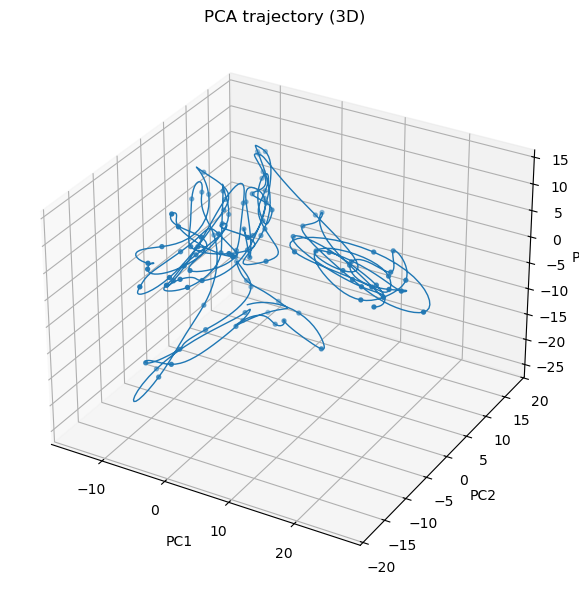

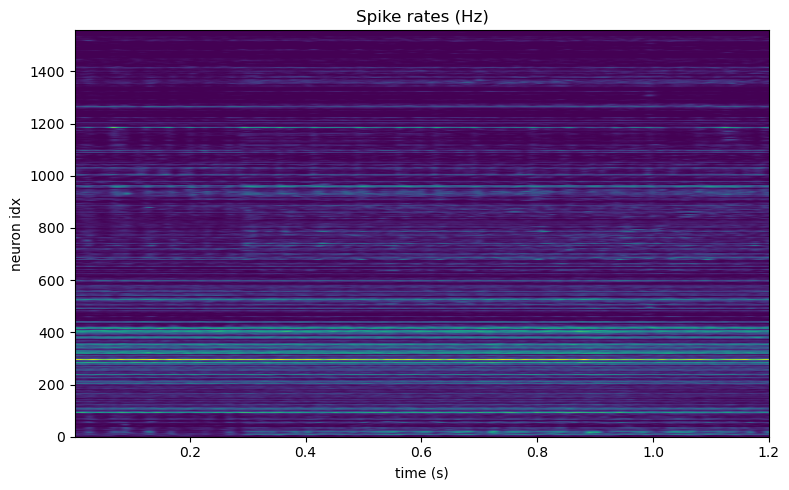

In [12]:
# Principal Component Analysis
def load_counts_from_h5(h5_path: Path, trial_index: int = 0):
    with h5py.File(h5_path, "r") as f:
        trials = sorted(f.keys())
        if not trials:
            raise RuntimeError("No trials in HDF5.")
        key = trials[trial_index]
        M = f[key]["signals"][:]             # (T, 1 + 2N)
    t = M[:, 0].astype(float)
    S = M[:, 1::2].astype(float)            # spike counts (T, N)
    return t, S

def rebin_time_series(X: np.ndarray, factor: int) -> np.ndarray:
    if factor <= 1: return X
    T = (X.shape[0] // factor) * factor
    return X[:T].reshape(T // factor, factor, *X.shape[1:]).mean(axis=1)

def main(argv=None):
    ap = argparse.ArgumentParser()
    ap.add_argument("--gt", default=str(Path().resolve() / "ibl_ground_truth.h5"))
    ap.add_argument("--trial", type=int, default=0)
    ap.add_argument("--target-bin", type=float, default=0.050, help="seconds; 0 keeps original")
    ap.add_argument("--smooth-sigma", type=float, default=5.0, help="gaussian sigma (bins) on rates")
    ap.add_argument("--k", type=int, default=10, help="# PCA components for visualization")
    ap.add_argument("--downsample", type=int, default=1, help="plot every Nth timepoint")

    args = ap.parse_args(argv)

    # --- Load counts ---
    t, S = load_counts_from_h5(Path(args.gt), trial_index=args.trial)
    dt = float(np.median(np.diff(t)))
    if args.target_bin and args.target_bin > 0:
        factor = int(round(args.target_bin / dt))
        if factor < 1: factor = 1
        if factor > 1:
            S = rebin_time_series(S, factor)
            t = t[:S.shape[0]]
            dt *= factor

    # counts -> rates, smooth, z-score
    R = S / dt
    if args.smooth_sigma and args.smooth_sigma > 0:
        R = gaussian_filter1d(R, sigma=args.smooth_sigma, axis=0)
    X = (R - R.mean(0, keepdims=True)) / (R.std(0, keepdims=True) + 1e-8)

    # PCA (keep k for visuals, but compute full eigs for PR if you want)
    k = min(args.k, X.shape[1])
    pca = PCA(n_components=k, svd_solver="full")
    Z = pca.fit_transform(X)                       # (T, k)
    expl = pca.explained_variance_ratio_

    # Optional downsampling for plotting
    ds = max(1, args.downsample)
    t_plot = t[::ds]
    Zp = Z[::ds]

    # 1) Scree + cumulative
    plt.figure(figsize=(7,4))
    x = np.arange(1, k+1)
    plt.bar(x, expl, width=0.8)
    cum = np.cumsum(expl)
    plt.plot(x, cum, marker='o')
    plt.xlabel("PC")
    plt.ylabel("Variance explained")
    plt.title("Scree and cumulative variance")
    plt.tight_layout()

    # 2) 2D trajectory (PC1 vs PC2), colored by time
    plt.figure(figsize=(6,6))
    sc = plt.scatter(Zp[:,0], Zp[:,1], c=t_plot - t_plot[0], s=6)
    cb = plt.colorbar(sc); cb.set_label("time (s)")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA trajectory (2D)")
    plt.tight_layout()

    # 3) 3D trajectory (PC1–PC3)
    if Z.shape[1] >= 3:
        from mpl_toolkits.mplot3d import Axes3D  # noqa
        fig = plt.figure(figsize=(7,6))
        ax = fig.add_subplot(111, projection="3d")
        ax.plot(Zp[:,0], Zp[:,1], Zp[:,2], lw=1)
        p = Zp[::max(1,len(Zp)//100)]
        ax.scatter(p[:,0], p[:,1], p[:,2], s=8)
        ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
        ax.set_title("PCA trajectory (3D)")
        fig.tight_layout()

    # 4) Spike-rate heatmap (time × neurons)
    plt.figure(figsize=(8,5))
    # z-limited for visibility (optional)
    vmax = np.percentile(R, 99)
    plt.imshow(R.T, aspect='auto', origin='lower',
               extent=[t[0], t[-1], 0, R.shape[1]], vmin=0, vmax=vmax)
    plt.xlabel("time (s)"); plt.ylabel("neuron idx"); plt.title("Spike rates (Hz)")
    plt.tight_layout()

    plt.show()

main([])

Participation ratio: 338.0191124528363


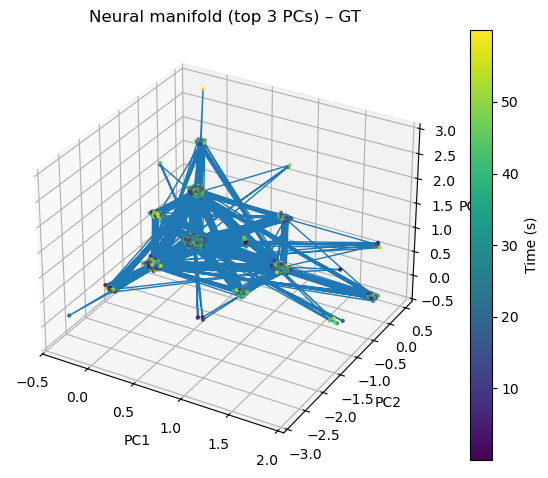

In [4]:
# Participation Ratio
GT_PATH  = Path(r"/metrics/datasets/ibl_ground_truth.h5")
SUB_PATH = Path(r"/metrics/datasets/ibl_submission.h5")

# choose which HDF5 to read
with h5py.File(GT_PATH, "r") as f:
    # take the first trial; change to loop/concat if you want all trials
    trial_key = sorted(f.keys())[0]
    M = f[trial_key]["signals"][:]             # shape: (T, 1 + 2*N)
    t = M[:, 0]                                # bin centers (seconds)
    counts_mat = M[:, 1::2]                    # spike counts columns (T, N)
    N = counts_mat.shape[1]

# bin edges that match these centers
dt = float(np.median(np.diff(t)))
edges = np.arange(t[0] - 0.5*dt, t[-1] + 0.5*dt + 1e-12, dt)

# reconstruct spike times per unit from counts (uses bin centers)
# NOTE: this can be large if counts are big; OK for short windows.
spike_trains = [np.repeat(t, counts_mat[:, i].astype(int)) for i in range(N)]
unit_names   = [f"neuron{i+1}" for i in range(N)]

# build spike-count matrix [time_bins * neurons]
spc_matrix = np.zeros((edges.size - 1, len(spike_trains)), dtype=float)
for i, st in enumerate(spike_trains):
    counts, _ = np.histogram(st, bins=edges)
    spc_matrix[:, i] = counts

# covariance calculation
spc_matrix_c = spc_matrix - spc_matrix.mean(axis=0, keepdims=True)
cov_matrix = (spc_matrix_c.T @ spc_matrix) / (spc_matrix.shape[0] - 1)
cov_matrix = 0.5 * (cov_matrix + cov_matrix.T) # symmetrize
tr, tr2 = np.trace(cov_matrix), np.trace(cov_matrix @ cov_matrix)

# calculate participation ratio
pr = (tr * tr) / tr2 if tr2 > 0 else np.nan

# display participation ratio
print("Participation ratio:", pr)


# PCA via SVD on centered spike-count matrix
U_t, s_vals, Vt = np.linalg.svd(spc_matrix_c, full_matrices=False)
V = Vt.T  # (neurons, neurons) – eigenvectors in neuron space

# take top 3 PCs
k = 3
PCs = V[:, :k]                 # (neurons, 3)
proj = spc_matrix_c @ PCs      # (time_bins, 3)

# Optionally subsample time for clarity
step = 5   # plot every 5th time bin
proj_sub = proj[::step]
t_sub = t[::step]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 3D trajectory over time
ax.plot(proj_sub[:, 0],
        proj_sub[:, 1],
        proj_sub[:, 2],
        lw=1.0)

p = ax.scatter(proj_sub[:, 0], proj_sub[:, 1], proj_sub[:, 2],
                c=t_sub, cmap='viridis', s=4)
fig.colorbar(p, ax=ax, label='Time (s)')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Neural manifold (top 3 PCs) – GT")
plt.tight_layout()
plt.show()

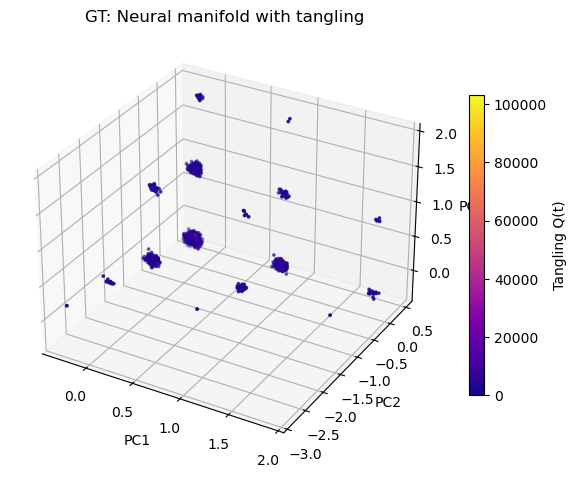

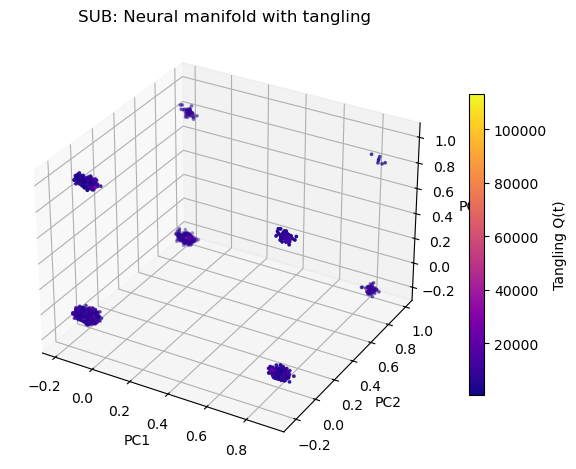

In [5]:
# Tangling

# ---------- Load your HDF5 ----------
GT_PATH  = Path(r"/metrics/datasets/ibl_ground_truth.h5")

with h5py.File(GT_PATH, "r") as f:
    trial_key  = sorted(f.keys())[0]
    M          = f[trial_key]["signals"][:]     # (T, 1 + 2*N)
    t          = M[:, 0]
    counts_mat = M[:, 1::2].astype(np.float32)  # spike counts (T, N)


SUB_PATH = Path(r"/metrics/datasets/ibl_submission.h5")


def load_spike_counts_and_time(h5_path):
    """
    Loads spike-count matrix and time vector from the first trial of an HDF5 file.
    Assumes:
      trial_xxx / "signals" dataset of shape (T, 1 + 2*N)
      col 0        = time (seconds)
      cols 1,3,5…  = spike counts
    Returns:
      spc_matrix: (T, N) spike counts
      t:          (T,)   time vector
      dt:         float  time step
    """
    with h5py.File(h5_path, "r") as f:
        trial_key = sorted(f.keys())[0]
        M = f[trial_key]["signals"][:]   # (T, 1 + 2N)
        t = M[:, 0]
        counts_mat = M[:, 1::2]         # (T, N)

    # optional: drop completely silent units
    keep = np.where(counts_mat.sum(axis=0) > 0)[0]
    spc_matrix = counts_mat[:, keep]

    dt = float(np.median(np.diff(t)))
    return spc_matrix, t, dt


def pca_to_3d(spc_matrix):
    """
    Center spike-count matrix and project into top-3 PCs via SVD.
    spc_matrix: (T, N)
    Returns:
      proj: (T, 3) trajectory in PC space
    """
    X = spc_matrix - spc_matrix.mean(axis=0, keepdims=True)
    # SVD: X = U_t S V^T
    U_t, s_vals, Vt = np.linalg.svd(X, full_matrices=False)
    V = Vt.T  # (N, N)
    PCs = V[:, :3]        # (N, 3)
    proj = X @ PCs        # (T, 3)
    return proj


def compute_tangling_local(proj, dt, step=10, r_min=1e-3, r_max=0.2, eps=1e-6):
    X = proj[::step]
    dX = np.gradient(X, dt * step, axis=0)
    T_sub = X.shape[0]
    Q = np.zeros(T_sub)

    for i in range(T_sub):
        diff_x = X[i] - X
        dist_x = np.linalg.norm(diff_x, axis=1)

        neighbors = (dist_x > r_min) & (dist_x < r_max)
        if not np.any(neighbors):
            Q[i] = 0.0
            continue

        diff_dx = dX[i] - dX
        dist_dx = np.linalg.norm(diff_dx, axis=1)

        ratio = dist_dx[neighbors] / (dist_x[neighbors] + eps)
        Q[i] = np.max(ratio)

    return Q, X



# --- approximate tangling ---
# dt already computed earlier from your time vector t
# proj has time step dt between rows

def plot_tangling_3d(h5_path, title, step=10):
    """
    Full pipeline for one dataset:
      - load spike counts
      - PCA to 3D
      - compute tangling
      - 3D scatter colored by Q(t)
    """
    spc_matrix, t, dt = load_spike_counts_and_time(h5_path)
    proj = pca_to_3d(spc_matrix)
    Q, X_sub = compute_tangling_local(proj, dt, step=step)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(
        X_sub[:, 0],
        X_sub[:, 1],
        X_sub[:, 2],
        c=Q,
        cmap='plasma',
        s=3
    )

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(title)

    cb = fig.colorbar(sc, ax=ax, shrink=0.7)
    cb.set_label("Tangling Q(t)")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # GT tangling visualization (3D)
    plot_tangling_3d(GT_PATH, "GT: Neural manifold with tangling", step=10)

    # SUB tangling visualization (3D) – separate figure
    plot_tangling_3d(SUB_PATH, "SUB: Neural manifold with tangling", step=10)




GT shape: (60000, 1557)
SUB shape: (60000, 1557)
Singular values (cos θ_i): [0.99627332 0.99562048 0.99362247 0.99131797 0.985067   0.97841819
 0.93864998 0.89616336 0.84337055 0.03071665]
Principal angles (deg):    [ 4.94804751  5.36425715  6.47433182  7.55549724  9.91409433 11.92520314
 20.17393992 26.34174651 32.50222826 88.23978889]
First principal angle (deg): 4.948047507269466


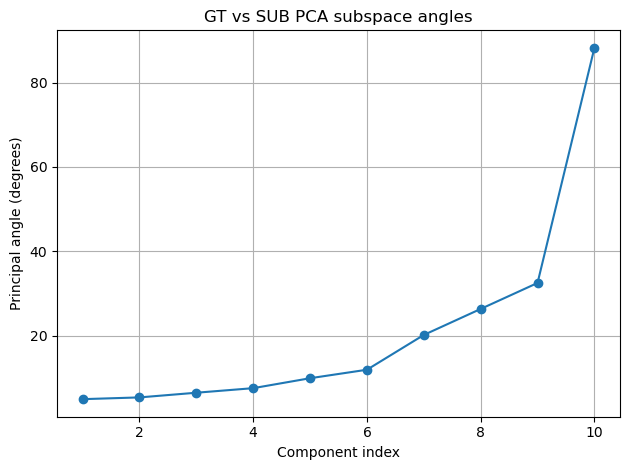

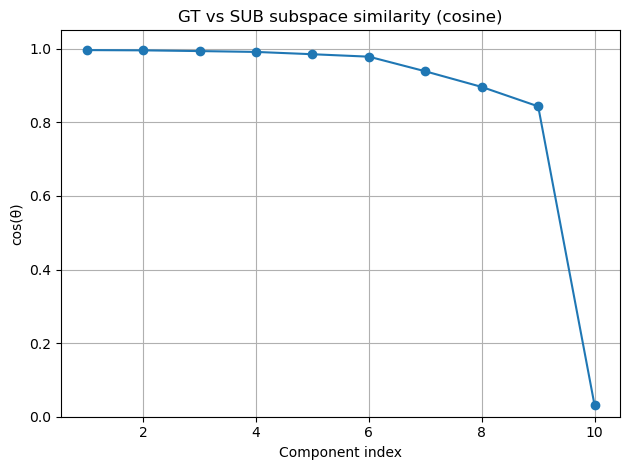

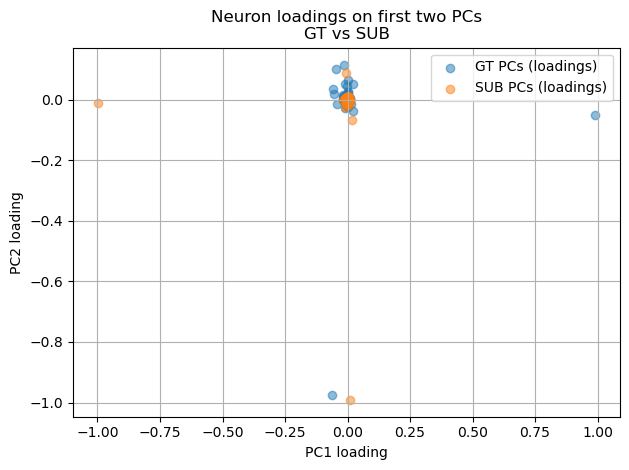

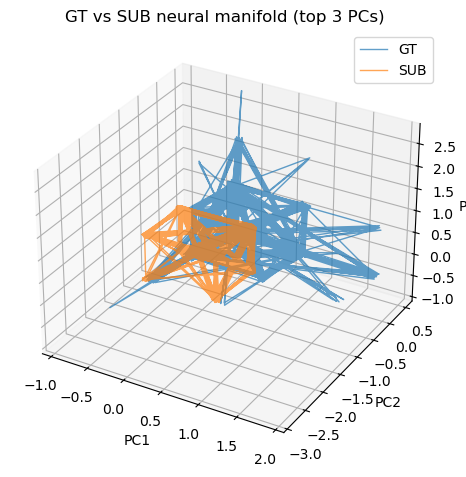

In [6]:
# Subspace Angle

GT_PATH  = Path(r"/metrics/datasets/ibl_ground_truth.h5")
SUB_PATH = Path(r"/metrics/datasets/ibl_submission.h5")


def load_spike_counts(h5_path):
    """
    Load spike-count matrix (time_bins x neurons) from the first trial
    in the given HDF5 file. Assumes dataset 'signals' with pattern:
      col 0 = time
      cols 1,3,5,... = spike counts
    """
    with h5py.File(h5_path, "r") as f:
        trial_key = sorted(f.keys())[0]          # e.g. 'trial_0000'
        M = f[trial_key]["signals"][:]           # (T, 1 + 2*N)
        counts_mat = M[:, 1::2]                  # spike counts: (T, N)

    return counts_mat


def pca_basis(spc_matrix, n_components=10):
    """
    spc_matrix: (time_bins, neurons)
    returns U: (neurons, k) with orthonormal columns (top k PCs)
    """
    X = spc_matrix - spc_matrix.mean(axis=0, keepdims=True)  # center
    U_t, s, Vt = np.linalg.svd(X, full_matrices=False)       # X = U_t S Vt
    V = Vt.T                                                 # (neurons, neurons)

    k = min(n_components, V.shape[1])
    U = V[:, :k]
    return U


def pca_subspace_angles(U_A, U_B):
    """
    Compute principal angles between two subspaces spanned by columns
    of U_A and U_B (assumed orthonormal).
    Returns:
        theta: array of angles in radians (theta[0] = smallest)
        s:     singular values = cos(theta_i)
    """
    k = min(U_A.shape[1], U_B.shape[1])
    U1 = U_A[:, :k]
    U2 = U_B[:, :k]

    # overlap matrix
    M = U1.T @ U2               # (k, k)
    _, s, _ = np.linalg.svd(M)  # singular values
    s = np.clip(s, -1.0, 1.0)   # numerical safety

    theta = np.arccos(s)        # radians
    return theta, s


if __name__ == "__main__":
    # load GT and SUB spike-count matrices
    spc_GT  = load_spike_counts(GT_PATH)
    spc_SUB = load_spike_counts(SUB_PATH)

    print("GT shape:", spc_GT.shape)
    print("SUB shape:", spc_SUB.shape)

    # PCA bases
    k = 10  # subspace dimensionality to compare
    U_GT  = pca_basis(spc_GT,  n_components=k)
    U_SUB = pca_basis(spc_SUB, n_components=k)

    # subspace angles
    theta, s = pca_subspace_angles(U_GT, U_SUB)

    # summary
    theta_deg = np.degrees(theta)
    print("Singular values (cos θ_i):", s)
    print("Principal angles (deg):   ", theta_deg)
    print("First principal angle (deg):", theta_deg[0])


idx = np.arange(1, len(theta) + 1)  # 1..k
theta_deg = np.degrees(theta)

plt.figure()
plt.plot(idx, theta_deg, marker='o')
plt.xlabel("Component index")
plt.ylabel("Principal angle (degrees)")
plt.title("GT vs SUB PCA subspace angles")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(idx, s, marker='o')
plt.xlabel("Component index")
plt.ylabel("cos(θ)")
plt.title("GT vs SUB subspace similarity (cosine)")
plt.grid(True)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

# take first 2 PCs from each basis
U1 = U_GT[:, :2]   # (neurons, 2)
U2 = U_SUB[:, :2]  # (neurons, 2)

plt.figure()
plt.scatter(U1[:, 0], U1[:, 1], alpha=0.5, label="GT PCs (loadings)")
plt.scatter(U2[:, 0], U2[:, 1], alpha=0.5, label="SUB PCs (loadings)")
plt.xlabel("PC1 loading")
plt.ylabel("PC2 loading")
plt.title("Neuron loadings on first two PCs\nGT vs SUB")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from mpl_toolkits.mplot3d import Axes3D  # just importing enables 3D

# --- project GT and SUB data into their own top-3 PC spaces ---

# center in time
X_GT  = spc_GT  - spc_GT.mean(axis=0, keepdims=True)   # (T, N)
X_SUB = spc_SUB - spc_SUB.mean(axis=0, keepdims=True)  # (T, N)

# project onto first 3 PCs in neuron space
GT_proj  = X_GT  @ U_GT[:, :3]   # (T, 3)
SUB_proj = X_SUB @ U_SUB[:, :3]  # (T, 3)

# --- 3D plot of trajectories / point clouds ---

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# you can use a subset of time points if it's too dense
idx = slice(0, GT_proj.shape[0], 5)  # every 5th point, for clarity

ax.plot(GT_proj[idx, 0], GT_proj[idx, 1], GT_proj[idx, 2],
        alpha=0.7, label='GT', linewidth=1)
ax.plot(SUB_proj[idx, 0], SUB_proj[idx, 1], SUB_proj[idx, 2],
        alpha=0.7, label='SUB', linewidth=1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('GT vs SUB neural manifold (top 3 PCs)')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Procrustes Distance

GT_PATH  = Path(r"/metrics/datasets/ibl_ground_truth.h5")
SUB_PATH = Path(r"/metrics/datasets/ibl_submission.h5")

def load_spike_counts(h5_path, drop_silent=False, keep_idx=None):
    with h5py.File(h5_path, "r") as f:
        trial_key = sorted(f.keys())[0]
        M = f[trial_key]["signals"][:]      # (T, 1 + 2*N)
        counts_mat = M[:, 1::2]             # (T, N)

    if keep_idx is not None:
        counts_mat = counts_mat[:, keep_idx]
    elif drop_silent:
        keep = np.where(counts_mat.sum(axis=0) > 0)[0]
        counts_mat = counts_mat[:, keep]
        return counts_mat, keep

    return counts_mat


def pca_basis(spc_matrix, k=10):
    """
    spc_matrix: (time_bins, neurons)
    returns basis U of shape (neurons, k) with orthonormal columns
    """
    # center in time
    X = spc_matrix - spc_matrix.mean(axis=0, keepdims=True)  # (T, N)

    # SVD-based PCA: X = U_t @ diag(s) @ Vt
    U_t, s, Vt = np.linalg.svd(X, full_matrices=False)
    V = Vt.T  # (N, N) eigenvectors in neuron space

    k = min(k, V.shape[1])
    U = V[:, :k]  # first k PCs, columns are orthonormal
    return U

def procrustes_subspace_distance(U1, U2):
    # U1, U2: (N, k), columns orthonormal (PCA)
    M = U1.T @ U2            # (k, k)
    _, s, _ = np.linalg.svd(M)   # singular values s_i
    s = np.clip(s, -1.0, 1.0)    # numerical safety

    # similarity = mean cosine of principal angles
    similarity = np.mean(s)      # in [0, 1]

    # Procrustes-style distance in [0, 1]
    distance = 1.0 - similarity
    return distance, similarity

# --- load GT and SUB spike-count matrices ---
spc_GT  = load_spike_counts(GT_PATH)   # (T, N_gt)
spc_SUB = load_spike_counts(SUB_PATH)  # (T, N_sub)

print("GT shape:", spc_GT.shape)
print("SUB shape:", spc_SUB.shape)

# --- build PCA bases for each ---
k = 10  # or whatever dimensionality you want, <= min(N_gt, N_sub)
U_GT  = pca_basis(spc_GT,  k=k)  # (N_gt_useful, k)
U_SUB = pca_basis(spc_SUB, k=k)  # (N_sub_useful, k)


# --- Procrustes distance between GT and SUB PCA subspaces ---
dist, svals = procrustes_subspace_distance(U_GT, U_SUB)

print("Procrustes subspace distance:", dist)
print("Singular values (cos θ_i):", svals)

GT shape: (60000, 1557)
SUB shape: (60000, 1557)
